# Airline fare price prediction

Using the dataset provided by [lalit_joshi](https://www.kaggle.com/datasets/lalitjoshi89/airlinepriceprediction)

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import unicodedata

In [2]:
# Loading "raw" data from csv for a quick glance
train_data = pd.read_csv(r'dataset/airlines_data.csv')
train_data.info

<bound method DataFrame.info of      ;Airline_Name;Date_of_Journey;Source;Destination;Dept_Time;Total_Stops;Duration_of_Flight;Arr_Time;Fare
0     0;AirAsia;26/02/2022;Kolkata;Mumbai;13:30;1 st...                                                     
1     1;AirAsia;26/02/2022;Kolkata;Mumbai;9:05;2 sto...                                                     
2     2;AirAsia;26/02/2022;Kolkata;Mumbai;16:15;1 st...                                                     
3     3;AirAsia;26/02/2022;Kolkata;Mumbai;23:40;1 st...                                                     
4     4;AirAsia;26/02/2022;Kolkata;Mumbai;20:00;1 st...                                                     
...                                                 ...                                                     
2016  2019;Vistara;10/7/22;Mumbai;Chennai;6:20;2 Sto...                                                     
2017  2020;Vistara;10/7/22;Mumbai;Chennai;11:25;2 St...                                         

### The Dataset

The data comes in a excel file format which I re-exported as a csv directly from Excel (note this could have been done using python too.)

In the data we have 10 variables and 2021 features. But we get all in 1 column due to the file being delimeted by semicolon. Lets fix that!

In [3]:
# Loading the data  with necessary attribute to convert it correctly into a dataframe
train_data = pd.read_csv(r'dataset/airlines_data.csv', delimiter=';', thousands=' ')
train_data

,Unnamed: 0,Airline_Name,Date_of_Journey,Source,Destination,Dept_Time,Total_Stops,Duration_of_Flight,Arr_Time,Fare
0,0,AirAsia,26/02/2022,Kolkata,Mumbai,13:30,1 stop,07 h 05 m,20:35,3 379
1,1,AirAsia,26/02/2022,Kolkata,Mumbai,9:05,2 stop,13 h 10 m,22:15,3 379
2,2,AirAsia,26/02/2022,Kolkata,Mumbai,16:15,1 stop,08 h 20 m,0:35,3 379
3,3,AirAsia,26/02/2022,Kolkata,Mumbai,23:40,1 stop,06 h 55 m,6:35,3 379
4,4,AirAsia,26/02/2022,Kolkata,Mumbai,20:00,1 stop,10 h 35 m,6:35,3 379
...,...,...,...,...,...,...,...,...,...,...
2016,2019,Vistara,10/7/22,Mumbai,Chennai,6:20,2 Stop,13h 55m,20:15,15 192
2017,2020,Vistara,10/7/22,Mumbai,Chennai,11:25,2 Stop,11h 20m,22:45,16 442
2018,2021,Vistara,10/7/22,Mumbai,Chennai,6:45,2 Stop,13h 30m,20:15,16 442
2019,2022,Vistara,10/7/22,Mumbai,Chennai,9:05,2 Stop,11h 10m,20:15,17 282


In [4]:
# Observing data types
train_data.dtypes

Unnamed: 0             int64
Airline_Name          object
Date_of_Journey       object
Source                object
Destination           object
Dept_Time             object
Total_Stops           object
Duration_of_Flight    object
Arr_Time              object
Fare                  object
dtype: object

In [5]:
# Checking for missing values
train_data.isnull().sum()

Unnamed: 0            0
Airline_Name          0
Date_of_Journey       0
Source                0
Destination           0
Dept_Time             0
Total_Stops           0
Duration_of_Flight    0
Arr_Time              0
Fare                  0
dtype: int64

### **Good!** and **Bad!**

Now there are some obvious observations that need to be address such as:

- The first `Unnamed` feature is redundant  and needs to be impute as it seems index.
- There is inconsistenacy on the date format on the `Date_of_Journey` feature
- The `Total_Stops` feature should be converted to numerical values.

A lot of our data is not the proper type such as:
- `Date_of_Journey` should be `datetime`
- `Total_Stops` should be `int`
- `Fare` should be `int`

It would be a good idea to change the name of the features to shorter names.

I found that `Airline_Name`, `Source` and `Destination` have repeated or diferent instances of the same word and that needs to be change i.e.: "Air Asia" instead of "AirAsia" or "MAA" instead of Chennai.

In [6]:
# Imputing the  "Unnamed" feature
train_data.drop(train_data.columns[0], axis=1, inplace=True)
train_data.head()

In [7]:
# Renaming and reordering features.
new_cols = ["airline_name", "flight_date", "flight_dep", "flight_arr", "dep_time", "total_stops", "flight_time", "arr_time", "flight_fare"]
train_data.columns = new_cols

new_cols_ord = ["airline_name", "flight_date", "flight_dep", "dep_time", "flight_arr", "arr_time", "total_stops","flight_time", "flight_fare"]
train_data = train_data.reindex(columns=new_cols_ord)

train_data.head()

In [8]:
# Changing data type of flight_date to desire format: Y-M-D.
train_data['flight_date'] = pd.to_datetime(train_data['flight_date'])

train_data.head()

In [9]:
# Converting string to numerical values in total_flights feature.

"""numpy.where, is a vectorized version of if/else, with the 
condition constructed by str.contains"""

train_data['total_stops'] = np.where(train_data.total_stops.str.contains("1"), 1,
                    np.where(train_data.total_stops.str.contains("2"), 2, 
                    np.where(train_data.total_stops.str.contains("3"), 3, 0,
                    )
                )
            )

train_data.head()

,airline_name,flight_date,flight_dep,dep_time,flight_arr,arr_time,total_stops,flight_time,flight_fare
0,AirAsia,2022-02-26,Kolkata,13:30,Mumbai,20:35,1,07 h 05 m,3 379
1,AirAsia,2022-02-26,Kolkata,9:05,Mumbai,22:15,2,13 h 10 m,3 379
2,AirAsia,2022-02-26,Kolkata,16:15,Mumbai,0:35,1,08 h 20 m,3 379
3,AirAsia,2022-02-26,Kolkata,23:40,Mumbai,6:35,1,06 h 55 m,3 379
4,AirAsia,2022-02-26,Kolkata,20:00,Mumbai,6:35,1,10 h 35 m,3 379


In [10]:
# Changing "flight_fare" to int data type

"""The feature came with a unicode break '\xa0' the unicodedata.normalize() will remove this issue"""

train_data['flight_fare'] = train_data['flight_fare'].apply(lambda x: unicodedata.normalize("NFKD", x).replace(' ',''))
train_data['flight_fare'] = pd.to_numeric(train_data['flight_fare'])

train_data.head()

,airline_name,flight_date,flight_dep,dep_time,flight_arr,arr_time,total_stops,flight_time,flight_fare
0,AirAsia,2022-02-26,Kolkata,13:30,Mumbai,20:35,1,07 h 05 m,3379
1,AirAsia,2022-02-26,Kolkata,9:05,Mumbai,22:15,2,13 h 10 m,3379
2,AirAsia,2022-02-26,Kolkata,16:15,Mumbai,0:35,1,08 h 20 m,3379
3,AirAsia,2022-02-26,Kolkata,23:40,Mumbai,6:35,1,06 h 55 m,3379
4,AirAsia,2022-02-26,Kolkata,20:00,Mumbai,6:35,1,10 h 35 m,3379


In [11]:
# Removing repeated values on 'airline_name' feature
airline_values = {
    'Air Asia':'AirAsia',
    'Spicejet':'SpiceJet'
}

for key, value in airline_values.items():
    # Replace key character with value character in string
    train_data['airline_name'] = train_data['airline_name'].replace(key, value)

In [12]:
# Removing repeated values on 'flight_dep' feature
dest_values = {'DEL':'New Delhi', 'GAU': 'Guwahati',
                'MAA': 'Chennai', 'BLR':'Bangalore',
                'CCU':'Kolkata', 'BOM':'Mumbai',
                'Bengaluru':'Bangalore'}

for key, value in dest_values.items():
    # Replace key character with value character in string
    train_data['flight_dep'] = train_data['flight_dep'].replace(key, value)

In [13]:
# Removing repeated values on 'flight_arr' feature
for key, value in dest_values.items():
    # Replace key character with value character in string
    train_data['flight_arr'] = train_data['flight_arr'].replace(key, value)

train_data.head()

,airline_name,flight_date,flight_dep,dep_time,flight_arr,arr_time,total_stops,flight_time,flight_fare
0,AirAsia,2022-02-26,Kolkata,13:30,Mumbai,20:35,1,07 h 05 m,3379
1,AirAsia,2022-02-26,Kolkata,9:05,Mumbai,22:15,2,13 h 10 m,3379
2,AirAsia,2022-02-26,Kolkata,16:15,Mumbai,0:35,1,08 h 20 m,3379
3,AirAsia,2022-02-26,Kolkata,23:40,Mumbai,6:35,1,06 h 55 m,3379
4,AirAsia,2022-02-26,Kolkata,20:00,Mumbai,6:35,1,10 h 35 m,3379


In [14]:
# Creating a new feature with only the flight day
train_data['flight_day'] = pd.to_datetime(train_data.flight_date, format = "%Y-%m-%d").dt.day

In [15]:
# Creating a new feature with only the flight month
train_data['flight_month'] = pd.to_datetime(train_data.flight_date, format = "%Y-%m-%d").dt.month

In [16]:
# After the flight date has been use to create to new feature (flight_day, flight_month) we can drop it
train_data.drop(['flight_date'], axis = 1, inplace = True)
train_data.head()

,airline_name,flight_dep,dep_time,flight_arr,arr_time,total_stops,flight_time,flight_fare,flight_day,flight_month
0,AirAsia,Kolkata,13:30,Mumbai,20:35,1,07 h 05 m,3379,26,2
1,AirAsia,Kolkata,9:05,Mumbai,22:15,2,13 h 10 m,3379,26,2
2,AirAsia,Kolkata,16:15,Mumbai,0:35,1,08 h 20 m,3379,26,2
3,AirAsia,Kolkata,23:40,Mumbai,6:35,1,06 h 55 m,3379,26,2
4,AirAsia,Kolkata,20:00,Mumbai,6:35,1,10 h 35 m,3379,26,2


In [17]:
# Extracting the values from dep_time into new features

# Extracting the hours from the departure time
train_data['dep_hour'] = pd.to_datetime(train_data['dep_time']).dt.hour

# Extracting the minutes from the departure time
train_data['dep_min'] = pd.to_datetime(train_data['dep_time']).dt.minute

# Droping the dep_time feature
train_data.drop(['dep_time'], axis = 1, inplace = True)

In [18]:
# Same as with departure time now extracting the values from arr_time into new features

# Extracting the hours from the arrival time
train_data['arr_hour'] = pd.to_datetime(train_data['arr_time']).dt.hour

# Extracting the minutes from the arrival time
train_data['arr_min'] = pd.to_datetime(train_data['arr_time']).dt.minute

# Droping the flight_dep feature
train_data.drop(['arr_time'], axis = 1, inplace = True)
train_data.head()

,airline_name,flight_dep,flight_arr,total_stops,flight_time,flight_fare,flight_day,flight_month,dep_hour,dep_min,arr_hour,arr_min
0,AirAsia,Kolkata,Mumbai,1,07 h 05 m,3379,26,2,13,30,20,35
1,AirAsia,Kolkata,Mumbai,2,13 h 10 m,3379,26,2,9,5,22,15
2,AirAsia,Kolkata,Mumbai,1,08 h 20 m,3379,26,2,16,15,0,35
3,AirAsia,Kolkata,Mumbai,1,06 h 55 m,3379,26,2,23,40,6,35
4,AirAsia,Kolkata,Mumbai,1,10 h 35 m,3379,26,2,20,0,6,35


In [19]:
# Extracting the flight time into hours and minutes from the flight_time feature

# Assigning and converting flight_time into a list
flight_time = list(train_data['flight_time'])

for i in range(len(flight_time)):
    if len(flight_time[i].split()) != 4: # Check if flight_time contains only hour or mins
        if 'h' in flight_time[i]:
            flight_time[i] = flight_time[i].strip() + ' 0m' # Adds 0 minute
        else:
            flight_time[i] = '0h ' + flight_time[i] # Adds 0 hours

# Adding the hours and minutes to separate list to later convert into new features
flight_time_hrs = []
flight_time_mins = []

for i in range(len(flight_time)):
    flight_time_hrs.append(int(flight_time[i].split(sep = 'h')[0])) # Extracts the hours from flight_time
    flight_time_mins.append(int(flight_time[i].split(sep = 'm')[0].split()[-1])) # Extracts only minutes from flight_time


In [20]:
# Creating new features for every flight time hour and minute
train_data['flight_time_hrs'] = flight_time_hrs
train_data['flight_time_mins'] = flight_time_mins

# Droping the flight_time feature after the the new features have been created
train_data.drop(['flight_time'], axis = 1, inplace = True)
train_data.head()

,airline_name,flight_dep,flight_arr,total_stops,flight_fare,flight_day,flight_month,dep_hour,dep_min,arr_hour,arr_min,flight_time_hrs,flight_time_mins
0,AirAsia,Kolkata,Mumbai,1,3379,26,2,13,30,20,35,7,5
1,AirAsia,Kolkata,Mumbai,2,3379,26,2,9,5,22,15,13,10
2,AirAsia,Kolkata,Mumbai,1,3379,26,2,16,15,0,35,8,20
3,AirAsia,Kolkata,Mumbai,1,3379,26,2,23,40,6,35,6,55
4,AirAsia,Kolkata,Mumbai,1,3379,26,2,20,0,6,35,10,35


### It's Exploratory Data Analaysis o'clock

- Highest and lowest fare (More expensive or cheapest airline to flight with)
- Longest and shortest flight
- Cheapest

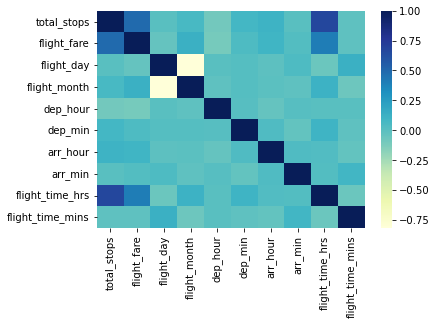

In [21]:
sns.heatmap(train_data.corr(), cmap="YlGnBu")
plt.show()

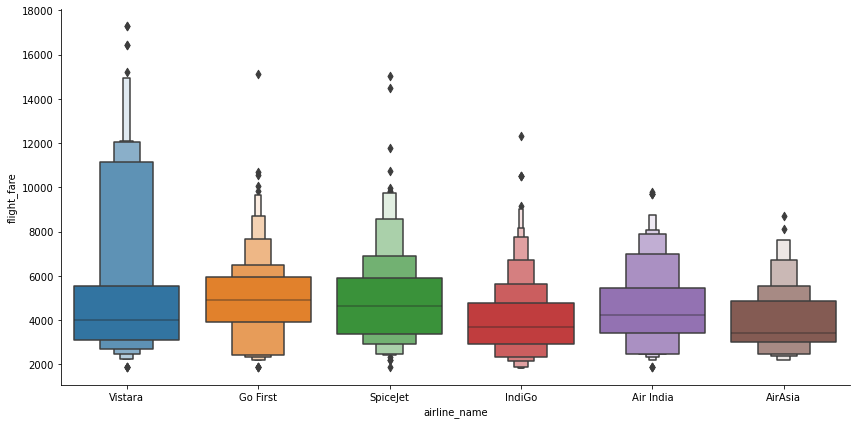

In [22]:
# Airline vs Price
sns.catplot(y = 'flight_fare', x = 'airline_name', data = train_data.sort_values("flight_fare", ascending = False), kind='boxen', height = 6, aspect = 2)
plt.show()

In [ ]:
# Unique values check cell
unique_vals = train_data['airline_name'].unique()
print(f"There are {len(unique_vals)} unique elements in this feature : {unique_vals} ")